In [7]:
import numpy as np
from qiskit import QuantumCircuit, transpile, BasicAer, IBMQ, execute, Aer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer import QasmSimulator

# Creating Oracle

An oracle in a quantum circuit is a "black box" which performs some operation. It can be thought of as a function in quantum gate form.
Because the functions the Deutsch-Jozsa algorithm looks at are constant(all outputs 0 or all outputs 1) or balanced(half of outputs 0 and half of outputs 1, in any order) that is what the oracle we create aims to do.
In the following cell we create the oracle by having it perform certain quantum gates depending on if we select it to be constant or balanced.

In [3]:
#Define oracle
def dj_oracle(type, n):
    oracle_qc = QuantumCircuit(n+1)
    if type == "constant":
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n) #Fixing all outputs to 0
            
    if type == "balanced":
        for qubit in range(n):
            oracle_qc.cx(qubit,n) #Adding CNOT gates to all qubits in the 1st register
            
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

## Creating Deutsch-Jozsa Quantum Cirucit

The circuit which performs the Deutsch-Jozsa algorithm is constructed in the cell below.
We have an n qubit register initialised in state |0> and an extra qubit flipped into the |1> state.
When coding this problem we can't let the oracle be either constant or balanced and find out later, we have to specifically select which type of oracle it is.

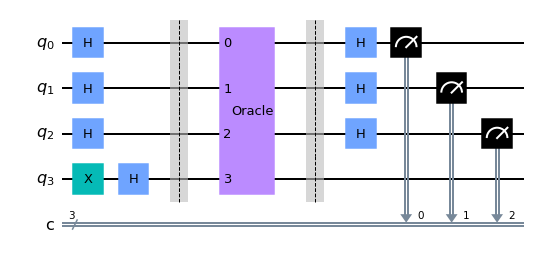

In [9]:
n=3
dj_circuit = QuantumCircuit(n+1, n)
dj_circuit.x(n)
dj_circuit.h(range(n+1))
dj_circuit.barrier()
oracle_gate = dj_oracle("balanced", n)
dj_circuit.append(oracle_gate, range(n+1))
dj_circuit.barrier()
dj_circuit.h(range(n))
dj_circuit.measure(range(n), range(n))
dj_circuit.draw('mpl')

## Simulation of Results

By executing our circuit on the noiseless simulator we obtain a single state as our result.
What we measure at the end of our circuit depends on if the oracle is constant of balanced.
If the oracle was constant we would measure 00...0 because it would not affect our total input quantum state and the application of the second set of hadamard gates would invert the n qubit register back to |00...0>.
If the oracle is balanced we can measure anything else.

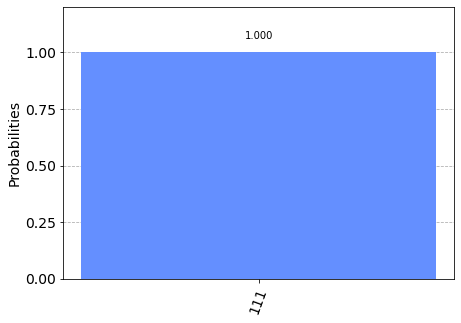

In [10]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(dj_circuit, backend, shots=1024).result().get_counts()
plot_histogram(job_sim)

## Running on Real Quantum Device

In the following cells we load the IBM account and check our providers and possible backends.

In [11]:
from qiskit import IBMQ
provider = IBMQ.enable_account('API Token')
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='qc-spring-22-4', group='group-4', project='reczA7aZpklv6xtnQ')>]

In [12]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

In this cell we check for the least busy device and select its coupling map and backend properties which are feautres of how the particular device works.

In [32]:
import qiskit.tools.jupyter

HW = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and not b.configuration().simulator and b.status().operational==True))
print(HW)
device = IBMQ.get_provider(hub='ibm-q', group='open', project='main').get_backend('ibmq_santiago')
coupling_map = device.configuration().coupling_map
backend_properties = device.properties()

ibmq_lima


In the cell we create and run a noise model using the calibration of the selected real quantum device. This is a way to generate noisy results based on real quantum hardware by running the circuit with a simulator on your own device and not waiting in a queue. The noisy results obtained this way will be similar to the real hardware but won't be exactly the same.

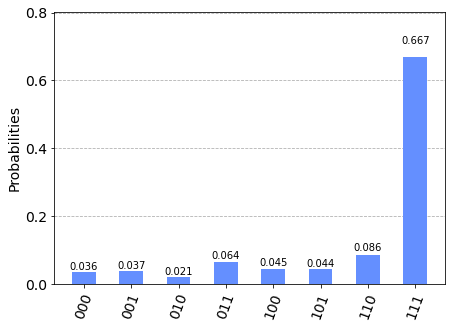

In [33]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import noise

# Creation of noise model and basis gate from backend properties

noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

bk = Aer.get_backend('qasm_simulator')
counts_noisy = execute(dj_circuit, shots=8192, backend=bk, coupling_map=coupling_map, 
                       basis_gates=basis_gates, noise_model=noise_model).result().get_counts()
plot_histogram(counts_noisy)

In this cell we run the circuit on the same quantum processor we created the noise model from.

In [ ]:
from qiskit.tools.monitor import job_monitor
bk_real = provider.get_backend('ibmq_santiago')
job_noisy_real = execute(dj_circuit, shots=8192, backend=bk_real)
job_monitor(job_noisy_real)

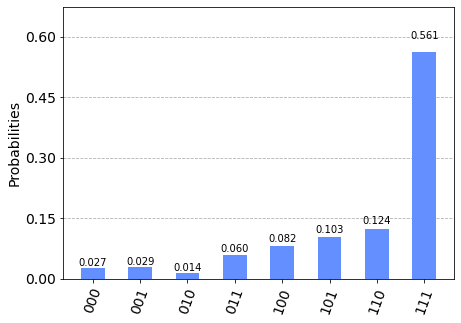

In [35]:
results_noisy_real = job_noisy_real.result()
counts_noisy_real = results_noisy_real.get_counts()
plot_histogram(counts_noisy_real)